In [1]:
# https://data.ontario.ca/dataset/confirmed-positive-cases-of-covid-19-in-ontario/resource/455fd63b-603d-4608-8216-7d8647f43350
# also use https://data.ontario.ca/dataset/status-of-covid-19-cases-in-ontario

# comparisons
# https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vTX5x2nxCde90Zwo83cdixZsyd_hU1orGsGYKpDe344wHeFi9MqI71aZYC6GLjOV_P2lp6_lUoacPNa/pubhtml?gid=1467787327&single=true
# https://twitter.com/jkwan_md/status/1312035412274221058?s=21
# https://russell-pollari.github.io/ontario-covid19/

import pandas as pd
import numpy as np
import urllib, json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection
import seaborn as sns
import datetime as dt
import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon

# set the standard plot size
plt.rcParams['figure.figsize']=(15,15)

In [2]:
# import data from the ontario open data API
# make sure to check the limit against current cases
url = "https://data.ontario.ca/en/api/3/action/datastore_search?resource_id=455fd63b-603d-4608-8216-7d8647f43350&limit=70000"
response = urllib.request.urlopen(url)
data = json.loads(response.read().decode('utf-8'))

# use this if you want to see the json
# print (data['result']['records'])

# use this if you want to write it to a pandas dataframe
df = pd.DataFrame(data['result']['records'])

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66686 entries, 0 to 66685
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _id                        66686 non-null  int64  
 1   Row_ID                     66686 non-null  int64  
 2   Accurate_Episode_Date      66684 non-null  object 
 3   Case_Reported_Date         66685 non-null  object 
 4   Test_Reported_Date         65755 non-null  object 
 5   Specimen_Date              43504 non-null  object 
 6   Age_Group                  66686 non-null  object 
 7   Client_Gender              66686 non-null  object 
 8   Case_AcquisitionInfo       66686 non-null  object 
 9   Outcome1                   66686 non-null  object 
 10  Outbreak_Related           66686 non-null  object 
 11  Reporting_PHU              66686 non-null  object 
 12  Reporting_PHU_Address      66686 non-null  object 
 13  Reporting_PHU_City         66686 non-null  obj

_id  Row_ID Accurate_Episode_Date   Case_Reported_Date  \
0    1       1   2020-09-07T00:00:00  2020-09-09T00:00:00   
1    2       2   2020-09-15T00:00:00  2020-09-17T00:00:00   
2    3       3   2020-10-18T00:00:00  2020-10-20T00:00:00   
3    4       4   2020-10-06T00:00:00  2020-10-11T00:00:00   
4    5       5   2020-10-11T00:00:00  2020-10-18T00:00:00   

    Test_Reported_Date        Specimen_Date Age_Group Client_Gender  \
0  2020-09-09T00:00:00  2020-09-07T00:00:00       <20          MALE   
1  2020-09-17T00:00:00  2020-09-16T00:00:00       20s        FEMALE   
2  2020-10-20T00:00:00  2020-10-18T00:00:00       40s        FEMALE   
3  2020-10-11T00:00:00  2020-10-06T00:00:00       50s          MALE   
4  2020-10-18T00:00:00  2020-10-18T00:00:00       40s          MALE   

  Case_AcquisitionInfo      Outcome1 Outbreak_Related  \
0                   CC      Resolved                    
1                   CC      Resolved                    
2  Missing Information  Not Resolved                    
3    No known epi link      Resolved                    
4    No known epi link  Not Resolved                    

                       Reporting_PHU   Reporting_PHU_Address  \
0  Region of Waterloo, Public Health  99 Regina Street South   
1                 Peel Public Health  7120 Hurontario Street   
2                 Peel Public Health  7120 Hurontario Street   
3                 Peel Public Health  7120 Hurontario Street   
4  Region of Waterloo, Public Health  99 Regina Street South   

  Reporting_PHU_City Reporting_PHU_Postal_Code      Reporting_PHU_Website  \
0           Waterloo                   N2J 4V3    www.regionofwaterloo.ca   
1        Mississauga                   L5W 1N4  www.peelregion.ca/health/   
2        Mississauga                   L5W 1N4  www.peelregion.ca/health/   
3        Mississauga                   L5W 1N4  www.peelregion.ca/health/   
4           Waterloo                   N2J 4V3    www.regionofwaterloo.ca   

   Reporting_PHU_Latitude  Reporting_PHU_Longitude  
0               43.462876               -80.520913  
1               43.647471               -79.708893  
2               43.647471               -79.708893  
3               43.647471               -79.708893  
4               43.462876               -80.520913

In [4]:
# sort by accurate episode date
df.sort_values(by=['Accurate_Episode_Date'], ascending=False);

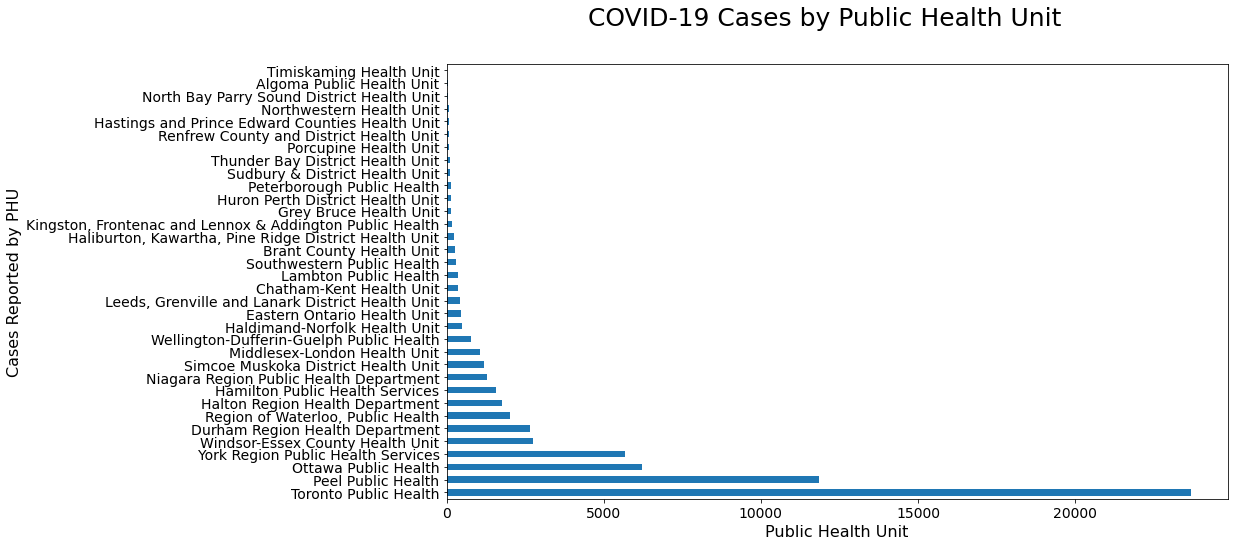

In [5]:
# plot cases by public health unit
fig = plt.figure()
fig.suptitle('COVID-19 Cases by Public Health Unit', fontsize=25) # Add the text/suptitle to figure

ax = df['Reporting_PHU'].value_counts().plot(
    kind='barh', 
    figsize=(14,8)
)
ax.set_xlabel("Public Health Unit", fontsize=16)
ax.set_ylabel("Cases Reported by PHU", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# if you want to save your graph
# fig.savefig('PHU.jpg')

In [6]:
df["Accurate_Episode_Date"] = df["Accurate_Episode_Date"].astype("datetime64")

In [7]:
df["Accurate_Episode_Date"].head()

0   2020-09-07
1   2020-09-15
2   2020-10-18
3   2020-10-06
4   2020-10-11
Name: Accurate_Episode_Date, dtype: datetime64[ns]

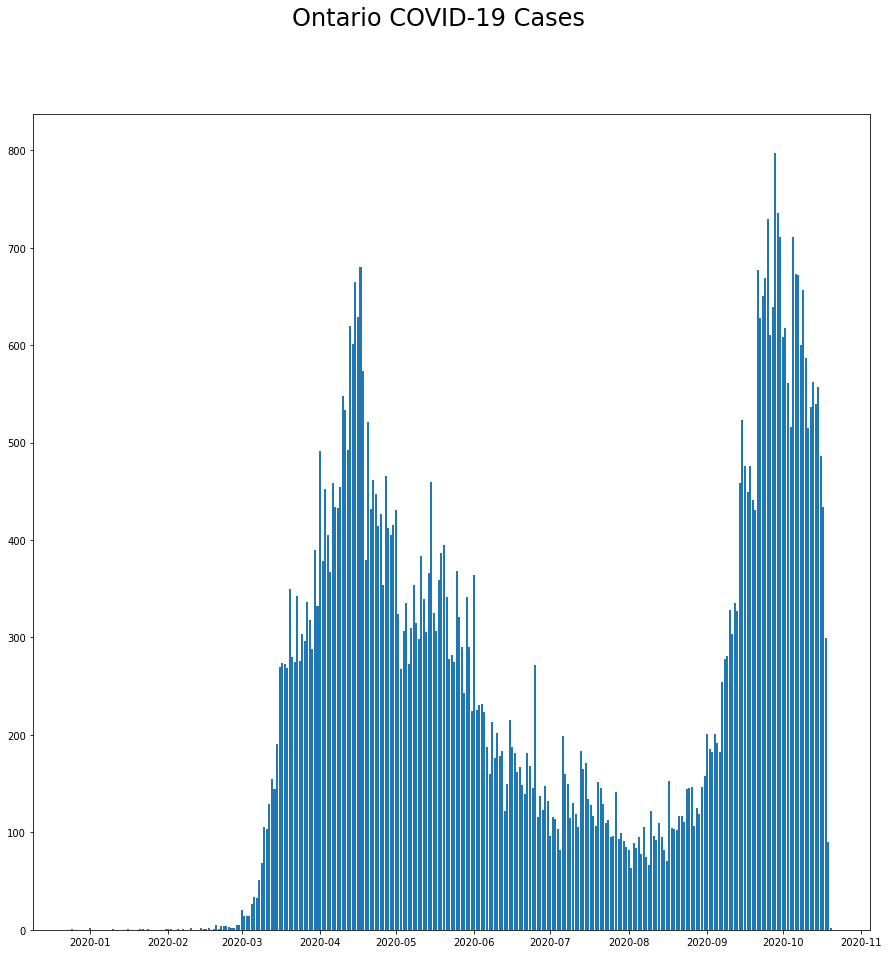

In [8]:
# use matplotlib to plot cases
fig = plt.figure()
fig.suptitle('Ontario COVID-19 Cases', fontsize=24) # Add the text/suptitle to figure

counts = df['Accurate_Episode_Date'].value_counts()
plt.bar(counts.index,counts)

# ax.set_xlabel("Public Health Unit", fontsize=16)
# ax.set_ylabel("Cases Reported by PHU", fontsize=16)
# ax.tick_params(axis='both', labelsize=14)
plt.show()

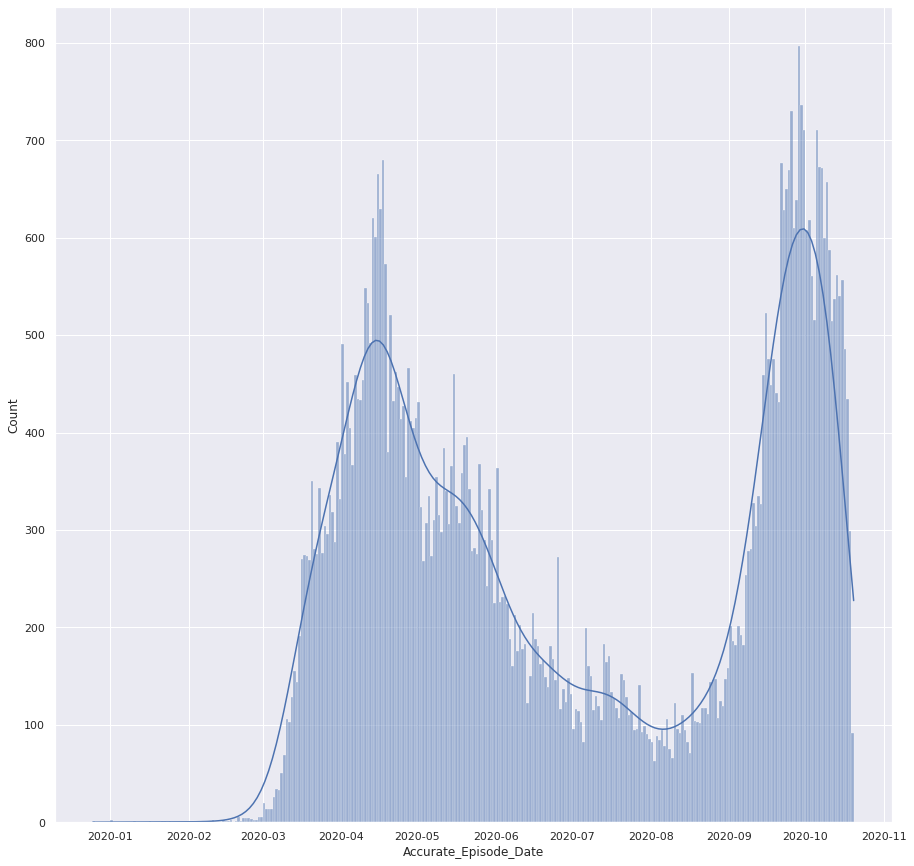

In [9]:
# same thing, but using seaborn lets us plot a kernel density estimate (which can visually stand in for a running average)
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html

sns.set()
ax = sns.histplot(df['Accurate_Episode_Date'], kde=True, bins=300)

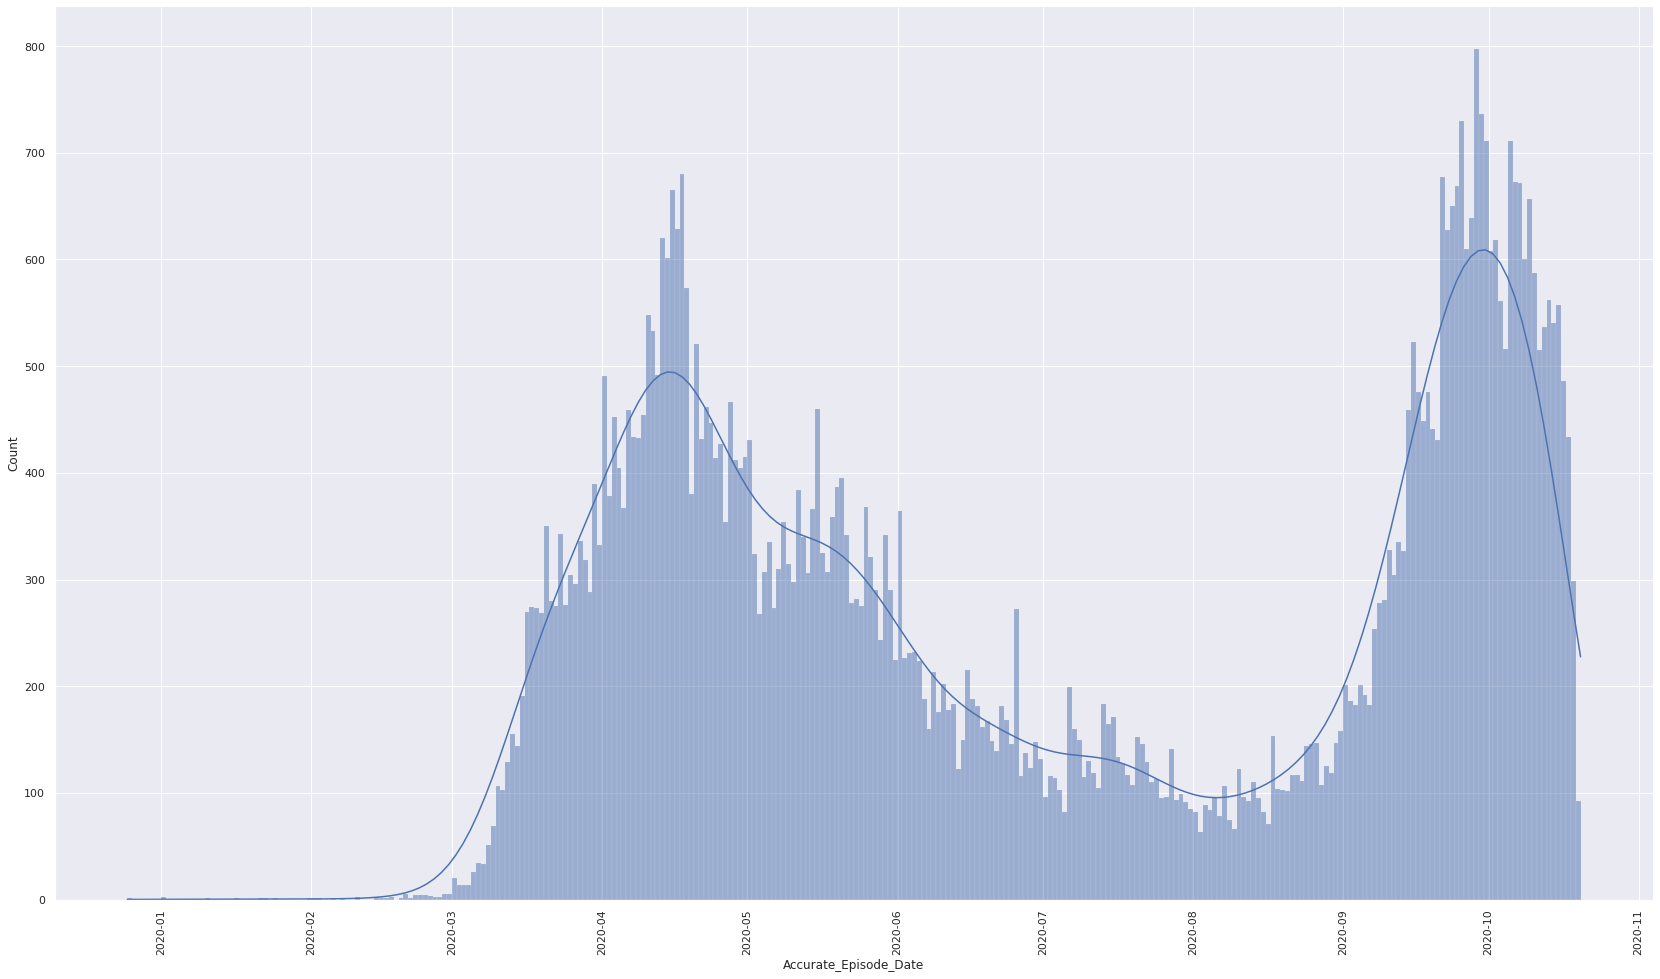

In [10]:
# using seaborn's displot method
g = sns.displot(df, x="Accurate_Episode_Date", kde=True, bins=300)
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(30,15) # and we'll use this to change the figure size

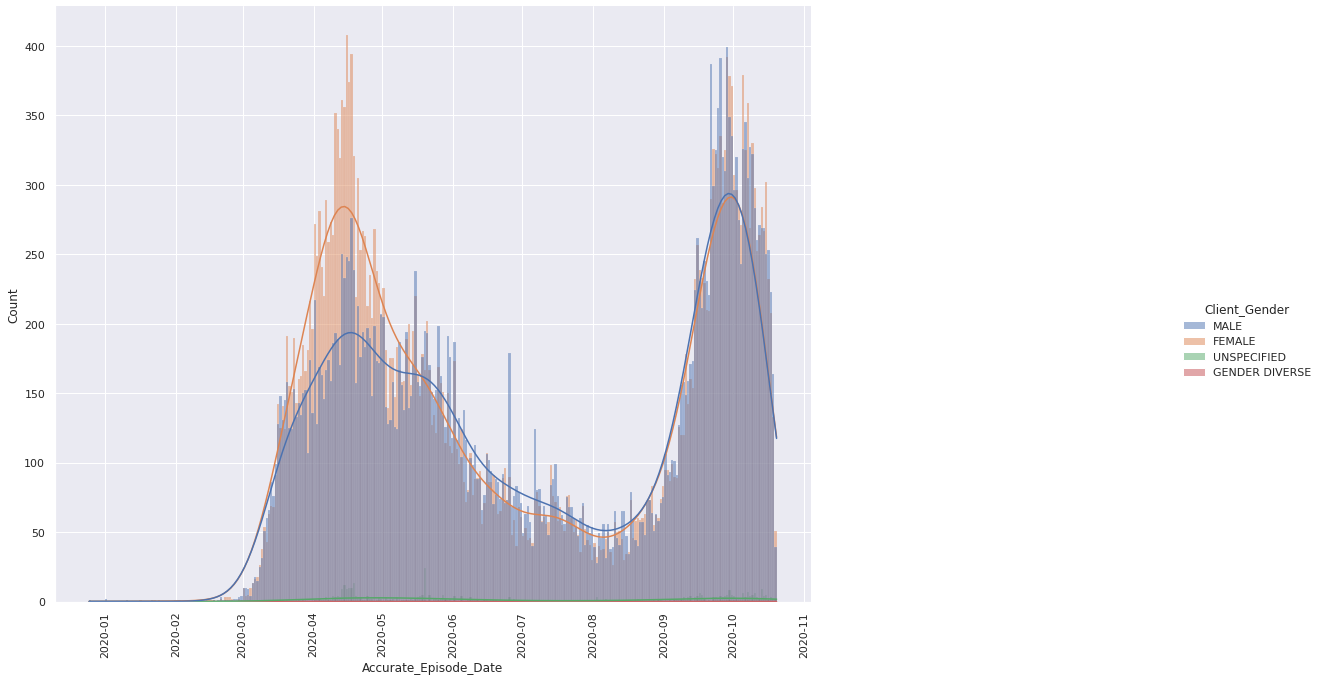

In [11]:
# comparisons based on gender
g = sns.displot(df, x="Accurate_Episode_Date", hue="Client_Gender", kde=True, bins=300)
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(20,10)

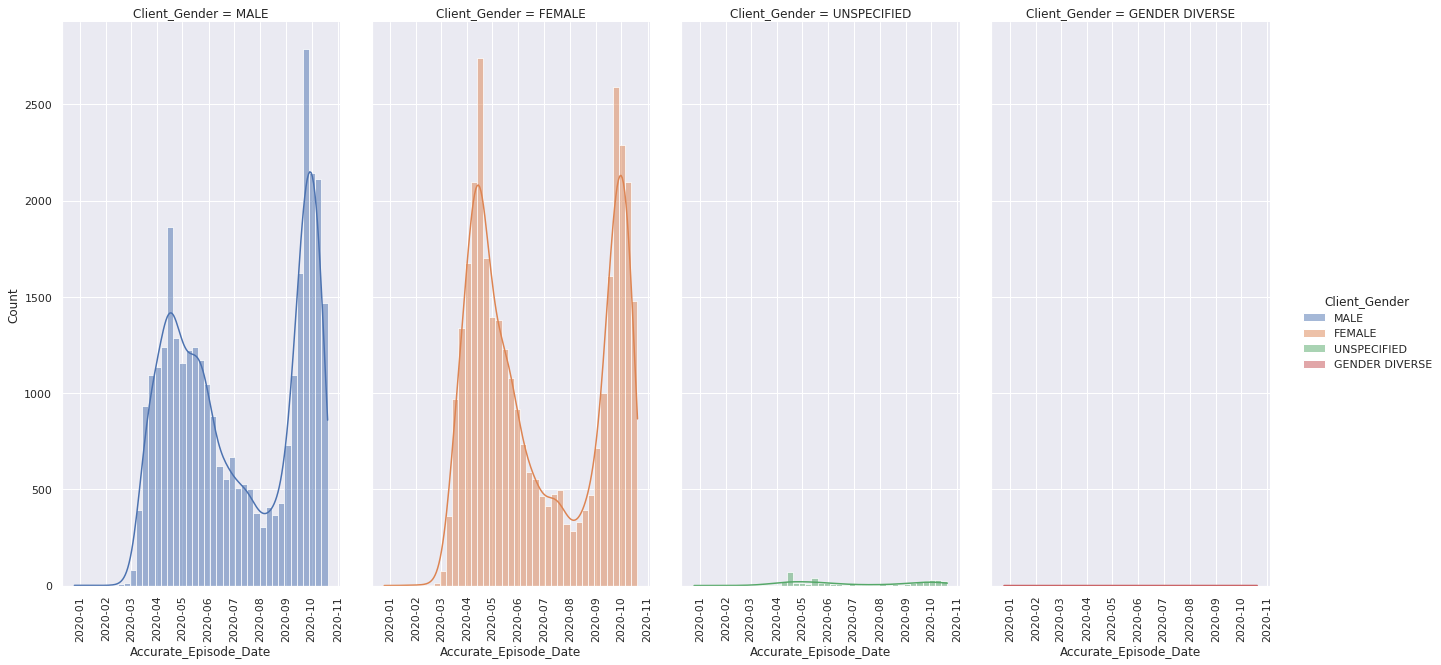

In [12]:
# side-by-side comparison based on gender
g = sns.displot(df, x="Accurate_Episode_Date", hue="Client_Gender", col="Client_Gender", kde=True)
g.set_xticklabels(rotation=90)
sns.set(font_scale=1.3) # seaborn's method for setting fontsize is pretty dumb
g.fig.set_size_inches(20,10)


# And what else might we consider visualizing while we're at it? Maybe age group by gender... 


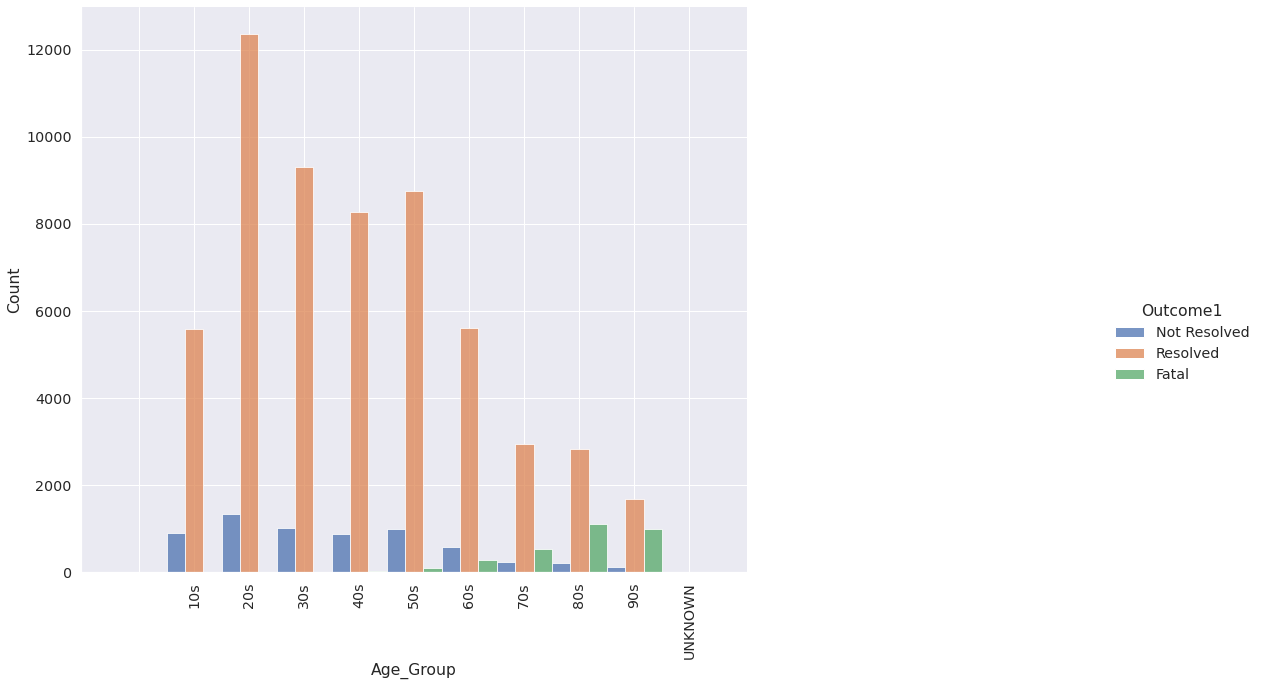

In [13]:
# or how about age group x outcome
df = df.replace(['<20'],'10s') # either re-set the order, or re-name <20 to something like 10s
df = df.sort_values('Age_Group', ascending=True) 

g = sns.displot(df, x="Age_Group", hue="Outcome1", multiple="dodge")
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(20,10)


# Some things to fix: 

* Re-order x axis (seaborn won't order age groups by default)
* Increase fonts (or change default matplotlib/seaborn options at the top of my notebook)
* Change colour palettes
* Make sure my H x W ratios are appropriate (see here: https://stats.stackexchange.com/questions/185346/what-is-the-best-ratio-between-width-and-height-in-a-bar-chart)
* Get rid of the NaNs in the dataset
* Make some more space between the age categories


## Let's look at all of Canada

     province_state country_region      lat      long       date  cases  \
0           Alberta         Canada  53.9333 -116.5765 2020-02-20      0   
1           Alberta         Canada  53.9333 -116.5765 2020-02-21      0   
2           Alberta         Canada  53.9333 -116.5765 2020-02-22      0   
3           Alberta         Canada  53.9333 -116.5765 2020-02-23      0   
4           Alberta         Canada  53.9333 -116.5765 2020-02-24      0   
...             ...            ...      ...       ...        ...    ...   
1185          Yukon         Canada  64.2823 -135.0000 2020-05-10     11   
1186          Yukon         Canada  64.2823 -135.0000 2020-05-11     11   
1187          Yukon         Canada  64.2823 -135.0000 2020-05-12     11   
1188          Yukon         Canada  64.2823 -135.0000 2020-05-13     11   
1189          Yukon         Canada  64.2823 -135.0000 2020-05-14     11   

           type    name alpha-3  
0     confirmed  Canada     CAN  
1     confirmed  Canada     CAN

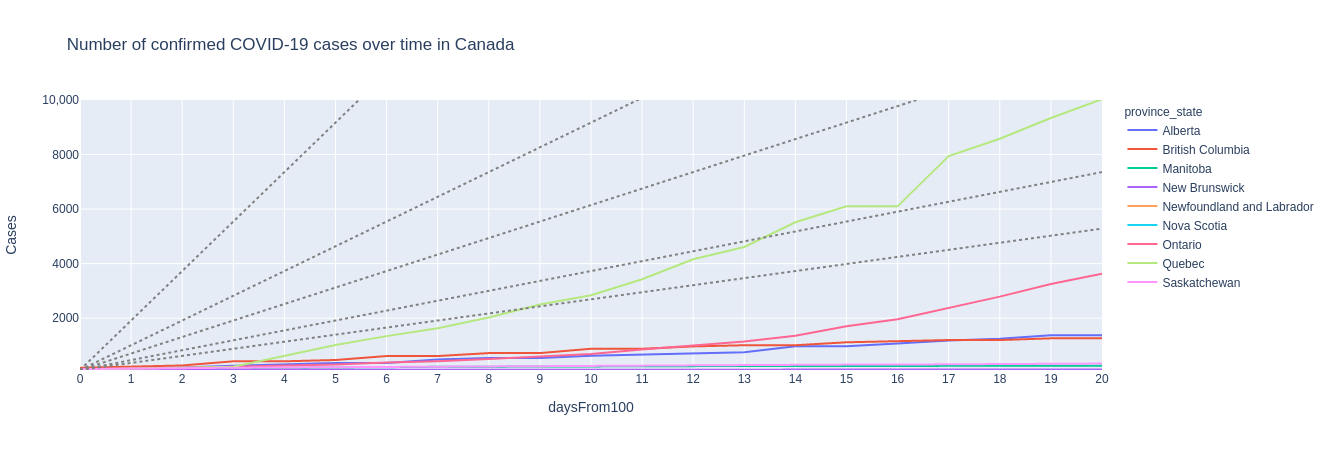

In [14]:
# this dataset module appears to be dead. too bad, since it renders simple plotly graphs.
# https://pypi.org/project/pycovid/
from pycovid import pycovid
pycovid.plot_provinces(
    country=['Canada'], 
    provinces=['Alberta', 
               'Ontario', 
               'Quebec', 
               'Manitoba', 
               'British Columbia', 
               'New Brunswick', 
               'Saskatchewan'],
    casetype=['confirmed'], 
    start_date="2020-02-20", 
    plottype="linear")

In [15]:
# here's another dataset module. this one is updated, but you'll have to visualize from scratch.
# https://pypi.org/project/covid/
from covid import Covid

In [16]:
covid = Covid()
covid.get_data();

In [17]:
canada_cases = covid.get_status_by_country_name("canada")
canada_cases

{'id': '33',
 'country': 'Canada',
 'confirmed': 209036,
 'active': 22644,
 'deaths': 9883,
 'recovered': 171405,
 'latitude': 60.001,
 'longitude': -95.001,
 'last_update': 1603365864000}

In [18]:
# and here's one final dataset module worth exploring
# https://pypi.org/project/covid19-data/
import covid19_data
canada = covid19_data.dataByName("Canada")
print(canada.deaths)

9883


In [19]:
# dix these so data can be grabbed directly from ontario data store
# import data from the ontario open data API
# make sure to check the limit against current cases
# geourl = "https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/4f39b02b-47fe-4e66-95b6-e6da879c6910/download/conposcovidloc.geojson"
# response = urllib.request.urlopen(geourl)
# data = json.loads(response.read().decode('utf-8'))

# geojson from ontario 
# https://data.ontario.ca/dataset/confirmed-positive-cases-of-covid-19-in-ontario
# https://data.ontario.ca/dataset/confirmed-positive-cases-of-covid-19-in-ontario/resource/4f39b02b-47fe-4e66-95b6-e6da879c6910

# with urllib.request.urlopen("https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/4f39b02b-47fe-4e66-95b6-e6da879c6910/download/conposcovidloc.geojson") as url:
#    fileobj = url.read()
#    print(fileobj)

# use this if you want to see the json
# print (data)

# use this if you want to write it to a pandas dataframe
# df = pd.DataFrame(data['result']['records'])


## Some Geodata Resources

- U of T map and data library resources https://mdl.library.utoronto.ca/collections/numeric-data/census-canada/2016/geo
- where to get geojson files https://stackoverflow.com/questions/17267248/how-where-do-i-get-geojson-data-for-states-provinces-and-administrative-region
- creating geojson from canada census divisions
https://blog.exploratory.io/making-maps-for-canadas-provisions-and-census-divisions-in-r-c189b88ccd8a
- creating geojson for toronto area codes https://medium.com/dataexplorations/generating-geojson-file-for-toronto-fsas-9b478a059f04
- ontario public health units https://geohub.lio.gov.on.ca/datasets/ministry-of-health-public-health-unit-boundary
- more ontario geodatasets https://geohub.lio.gov.on.ca/datasets/11be9127e6ae43c4850793a3a2ee943c_13
- potentially a fun shapefile to play with https://data.ontario.ca/dataset/provincially-licensed-meat-plants
- ttc shapefile https://open.toronto.ca/dataset/ttc-subway-shapefiles/

In [20]:
# let's slice up our original DF to get counts from each public health unit
df1 = df[['_id','Reporting_PHU','Outcome1']]

In [28]:
# need to fix all these so they write column names properly
resolved = df1[df1.Outcome1 == 'Resolved'].groupby(['Reporting_PHU']).agg(['count']).drop(['Outcome1'], axis=1)
resolved.to_csv('data/ontario_covid_resolved_by_phu.csv')
resolved.head()

count
                                count
Reporting_PHU                        
Algoma Public Health Unit          39
Brant County Health Unit          221
Chatham-Kent Health Unit          368
Durham Region Health Department  2289
Eastern Ontario Health Unit       326

In [22]:
not_resolved = df1[df1.Outcome1 == 'Not Resolved'].groupby(['Reporting_PHU']).agg(['count']).drop(['Outcome1'], axis=1)
not_resolved.to_csv('data/ontario_covid_active_by_phu.csv')
not_resolved.head()

_id
                                count
Reporting_PHU                        
Algoma Public Health Unit           1
Brant County Health Unit           56
Chatham-Kent Health Unit            7
Durham Region Health Department   180
Eastern Ontario Health Unit       106

In [23]:
fatal = df1[df1.Outcome1 == 'Fatal'].groupby(['Reporting_PHU']).agg(['count']).drop(['Outcome1'], axis=1)
fatal.to_csv('data/ontario_covid_deaths_by_phu.csv')
fatal.head()

_id
                                count
Reporting_PHU                        
Brant County Health Unit            6
Chatham-Kent Health Unit            3
Durham Region Health Department   182
Eastern Ontario Health Unit        14
Haldimand-Norfolk Health Unit      37

In [51]:
active_cases = pd.read_csv("data/ontario_covid_active_by_phu.csv")
active_cases.head()

Reporting_PHU  count
0        Algoma Public Health Unit      1
1         Brant County Health Unit     56
2         Chatham-Kent Health Unit      7
3  Durham Region Health Department    180
4      Eastern Ontario Health Unit    106

In [52]:
# fix the column names in the csv first
# explain how to generate the geojson files from shapefiles
map_ontario = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
ontario_geo = "./geodata/ontario_phu.geojson"
map_ontario.choropleth(geo_data=ontario_geo,
    data = active_cases,
    columns=['Reporting_PHU','count'],
    key_on='feature.properties.PHU_NAME_E',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Active Cases by Reporting PHU')   
    
map_ontario
# demonstrate how the PHU names in the public shapefile don't match

/home/gbby/.local/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



KeyError: "None of ['Reporting_PHU'] are in the columns"

In [33]:
# re-draw with neighbourhood data from the city https://drive.google.com/file/d/1jzH64LvFQ-UsDibXO0MOtvjbL2CvnV3N/view
# https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/
# set up to read from api instead of downloaded file
to_df = pd.read_excel('data/CityofToronto_COVID-19_NeighbourhoodData.xlsx', 1)

In [34]:
to_df.sort_values(by=['Neighbourhood Name'], ascending=True)

Neighbourhood ID            Neighbourhood Name  Rate per 100,000 people  \
128               129               Agincourt North               515.233744   
127               128  Agincourt South-Malvern West               450.393568   
19                 20                     Alderwood               630.496101   
94                 95                         Annex               750.180174   
41                 42             Banbury-Don Mills               299.693085   
..                ...                           ...                      ...   
93                 94                      Wychwood               836.295212   
99                100                Yonge-Eglinton               313.108234   
96                 97                Yonge-St.Clair               351.213282   
26                 27       York University Heights              2221.577936   
30                 31            Yorkdale-Glen Park              2094.028641   

     Case Count  
128         150  
127         107  
19           76  
94          229  
41           83  
..          ...  
93          120  
99           37  
96           44  
26          613  
30          310  

[140 rows x 4 columns]

In [35]:
# to_df['Neighbourhood ID'].dropna
# find name of one of the neighbourhoods that doesn't show up because of name discrepancy
to_df[to_df['Neighbourhood Name'].str.contains("Cabbagetown")]

Neighbourhood ID                Neighbourhood Name  \
70                71  Cabbagetown-South St. James Town   

    Rate per 100,000 people  Case Count  
70               711.286314          83

In [37]:
# clean up file names in the geojson with geopandas

In [38]:
to_geo = gpd.read_file("geodata/to_neighbourhoods.geojson")
to_geo.head()

AREA_S_CD                     AREA_NAME  \
0        97           Yonge-St.Clair (97)   
1        27  York University Heights (27)   
2        38         Lansing-Westgate (38)   
3        31       Yorkdale-Glen Park (31)   
4        16      Stonegate-Queensway (16)   

                                            geometry  
0  MULTIPOLYGON (((-79.39119 43.68108, -79.39141 ...  
1  MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...  
2  MULTIPOLYGON (((-79.43998 43.76156, -79.44004 ...  
3  MULTIPOLYGON (((-79.43969 43.70561, -79.44011 ...  
4  MULTIPOLYGON (((-79.49262 43.64744, -79.49277 ...

In [39]:
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].str.replace(" \\(\\d+\\)", "")   

In [40]:
to_geo.sort_values(by=['AREA_NAME'], ascending=True)

AREA_S_CD                     AREA_NAME  \
79        129               Agincourt North   
80        128  Agincourt South-Malvern West   
86        020                     Alderwood   
56        095                         Annex   
84        042             Banbury-Don Mills   
..        ...                           ...   
137       094                      Wychwood   
128       100                Yonge-Eglinton   
0          97                Yonge-St.Clair   
1          27       York University Heights   
3          31            Yorkdale-Glen Park   

                                              geometry  
79   MULTIPOLYGON (((-79.24213 43.80247, -79.24319 ...  
80   MULTIPOLYGON (((-79.25498 43.78122, -79.25797 ...  
86   MULTIPOLYGON (((-79.54866 43.59022, -79.54876 ...  
56   MULTIPOLYGON (((-79.39414 43.66872, -79.39588 ...  
84   MULTIPOLYGON (((-79.33055 43.73979, -79.33044 ...  
..                                                 ...  
137  MULTIPOLYGON (((-79.43592 43.68015, -79.43492 ...  
128  MULTIPOLYGON (((-79.41096 43.70408, -79.40962 ...  
0    MULTIPOLYGON (((-79.39119 43.68108, -79.39141 ...  
1    MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...  
3    MULTIPOLYGON (((-79.43969 43.70561, -79.44011 ...  

[140 rows x 3 columns]

In [41]:
# fix Pelham Park
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].replace('Weston-Pellam Park', 'Weston-Pelham Park') 
# fix Cabbagetown
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].replace('Cabbagetown-South St.James Town', 'Cabbagetown-South St. James Town') 
# fix North St. James
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].replace('North St.James Town', 'North St. James Town')

In [42]:
# add case count from the pandas df to the geopandas df
to_geo['Case Count'] = to_df['Case Count']
# add rate from the pandas df to the geopandas df
to_geo['Rate Per 100,000'] = to_df['Rate per 100,000 people']

In [43]:
# change area name to neighbourhood
to_geo = to_geo.rename(columns={'AREA_NAME': "Neighbourhood"})

In [44]:
to_geo.sort_values(by=['Neighbourhood'], ascending=True)

AREA_S_CD                 Neighbourhood  \
79        129               Agincourt North   
80        128  Agincourt South-Malvern West   
86        020                     Alderwood   
56        095                         Annex   
84        042             Banbury-Don Mills   
..        ...                           ...   
137       094                      Wychwood   
128       100                Yonge-Eglinton   
0          97                Yonge-St.Clair   
1          27       York University Heights   
3          31            Yorkdale-Glen Park   

                                              geometry  Case Count  \
79   MULTIPOLYGON (((-79.24213 43.80247, -79.24319 ...          57   
80   MULTIPOLYGON (((-79.25498 43.78122, -79.25797 ...          90   
86   MULTIPOLYGON (((-79.54866 43.59022, -79.54876 ...         128   
56   MULTIPOLYGON (((-79.39414 43.66872, -79.39588 ...          48   
84   MULTIPOLYGON (((-79.33055 43.73979, -79.33044 ...         299   
..                                                 ...         ...   
137  MULTIPOLYGON (((-79.43592 43.68015, -79.43492 ...         207   
128  MULTIPOLYGON (((-79.41096 43.70408, -79.40962 ...         150   
0    MULTIPOLYGON (((-79.39119 43.68108, -79.39141 ...         700   
1    MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...         708   
3    MULTIPOLYGON (((-79.43969 43.70561, -79.44011 ...         186   

     Rate Per 100,000  
79         412.266744  
80         543.609568  
86         535.005225  
56         417.427602  
84        1368.483683  
..                ...  
137        908.851423  
128        515.233744  
0         2101.344861  
1         2148.449354  
3         1766.549530  

[140 rows x 5 columns]

In [45]:
# use this if you want to write output to new geojson file
# to_geo.to_file('geodata/to_geo.geojson', driver='GeoJSON')

In [48]:
# not interactive
map_toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
# toronto_geo = "./geodata/to_geo.geojson"
map_toronto.choropleth(geo_data=to_geo,
    data = to_df,
    columns=['Neighbourhood Name','Case Count'],
    key_on='feature.properties.Neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Case Counts by Neighbourhood')   
    
map_toronto
# demonstrate how the PHU names in the public shapefile don't match

In [49]:
map_to = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
# to_geo = "./geodata/to_geo.geojson"
map_to.choropleth(geo_data=to_geo,
    data = to_df,
    columns=['Neighbourhood Name','Rate per 100,000 people'],
    key_on='feature.properties.Neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rate per 100k by Neighbourhood')

folium.GeoJson(
        to_geo, 
        name='Toronto Neighbourhoods',
        show=True,
        style_function=lambda feature: {
            # 'fillColor': 'YlOrRd',
            'color': 'YlOrRd',
            'weight': .1,
            'dashArray': '5, 5',
            'fillOpacity':0
        },   
        highlight_function=lambda x: {'weight':1, 
                                      'color':'black'
                                      #'fillOpacity':1
                                     },    
        tooltip=folium.features.GeoJsonTooltip(
            fields=['Neighbourhood', 'Case Count', 'Rate Per 100,000'],
            labels=True,                              
        ),  
).add_to(map_to)
    
map_to

In [ ]:
# next steps: add 3D and customize tooltips
# https://towardsdatascience.com/an-interactive-3d-map-of-police-action-s-that-have-resulted-in-death-b9d7fbf81822
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# clean up tooltips https://towardsdatascience.com/using-folium-to-generate-choropleth-map-with-customised-tooltips-12e4cec42af2